In [51]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import confusion_matrix, mean_squared_error

import lightgbm as lgb
from prophet import Prophet

In [52]:
raw_df= pd.read_excel("../data/raw/kadai.xlsx")
raw_df.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


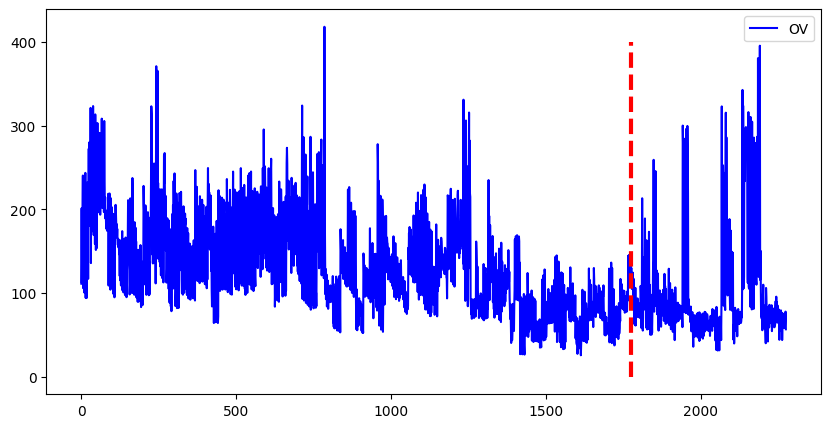

In [53]:
raw_data = pd.read_excel('../data/raw/kadai.xlsx')
plt.figure(figsize=(10, 5))
plt.plot(
    raw_data.index,
    raw_data["OV"],
    label="OV",
    color='blue',
)
plt.vlines(1776, 0,400, colors='red', linestyle='--', linewidth=3)
plt.legend()
plt.show()

In [54]:
processe = raw_df.copy()
processe["batch_id"] = processe.groupby("process_end_time").ngroup()
processe.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X75,X76,X77,X78,X79,X80,X81,X82,X83,batch_id
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0


In [55]:
# batch_id>75が、テストデータ
processe.iloc[1776]

process_end_time    2016-11-28 07:26:00
final_mes_time      2017-01-18 17:13:00
OV                             130.1202
X1                                23.62
X2                                 9.35
                           ...         
X80                                0.02
X81                                0.01
X82                                0.25
X83                                0.04
batch_id                             75
Name: 1776, Length: 87, dtype: object

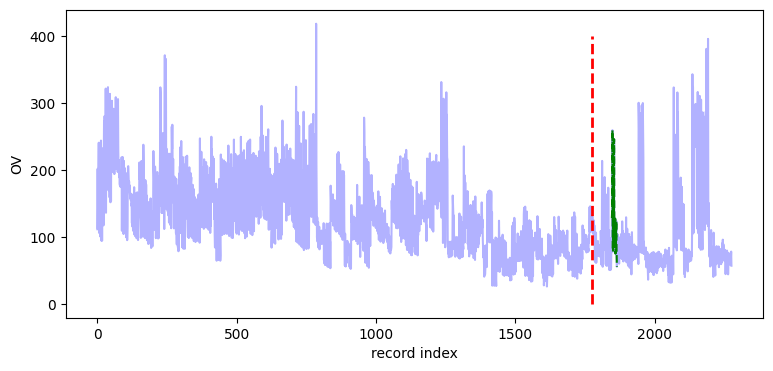

In [56]:
plt.figure(figsize=(9, 4))
plt.plot(
    processe.index,
    processe["OV"],
    label='OV',
    color='blue',
    linestyle='-',
    alpha=0.3
)
# labelsが1のみフィルタしてプロット
mask = processe["batch_id"] == 79
plt.plot(
    processe.index[mask],
    processe["OV"][mask],
    color='green',
    linestyle='--',

)
plt.vlines(1776, 0,400, colors='red', linestyle='--', linewidth=2)
plt.xlabel("record index")
plt.ylabel("OV")

plt.show()

In [57]:
threshold = 50
for batch in processe["batch_id"].unique():
    mask = processe["batch_id"] == batch
    std = processe.loc[mask, "OV"].std()
    processe.loc[mask, "batch_OV_std"] = std
    processe.loc[mask, "is_anomaly"] = int(std >= threshold)

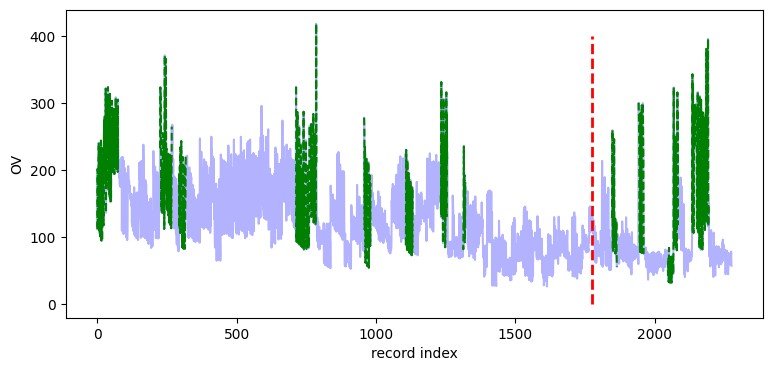

In [58]:
plt.figure(figsize=(9, 4))
plt.plot(
    processe.index,
    processe["OV"],
    label='OV',
    color='blue',
    linestyle='-',
    alpha=0.3
)
# labelsが1のみフィルタしてプロット
mask = processe["batch_OV_std"] >= threshold
y = processe["OV"].where(mask)  # mask=False → NaN
plt.plot(
    processe.index,
    y,
    color='green',
    linestyle='--'
)

plt.vlines(1776, 0,400, colors='red', linestyle='--', linewidth=2)
plt.xlabel("record index")
plt.ylabel("OV")

plt.show()

## 閾値(threshold) == 30として、分類RFを組む

In [59]:
processe.copy()
processe["is_anomaly"] = processe["is_anomaly"].astype(int)
learn = processe[:-500]
test = processe[-500:]
batch_id_anormal = processe[processe["is_anomaly"] == 1]["batch_id"].unique()

In [60]:
y = [1 if j in batch_id_anormal else 0 for j in range(0, 100)]
y[79]

1

In [72]:
processe.drop(columns=["process_end_time", "final_mes_time", "batch_OV_std", "OV"])
processe.to_csv("../data/processed/processe_tagged_anormaly.csv", index=False)

In [62]:
batch_describe_df = pd.DataFrame()
for batch in processe["batch_id"].unique():
    rec = (
        processe.loc[processe["batch_id"] == batch]
        .describe()
        .stack()
        .rename("value")
        .reset_index()
    )
    

    rec["feature"] = rec["level_0"] + "_" + rec["level_1"]

    cols = ["X36", "X27","X30", "X41"]
    #cols = [f"X{i}" for i in range(1, 84)]
    rec_wide = (
        processe.loc[processe["batch_id"] == batch, cols]
        .describe()
        .stack()
        .to_frame().T
    )

    # 列名をフラット化（任意）
    rec_wide.columns = [f"{c}_{stat}" for c, stat in rec_wide.columns]
    rec_wide
    batch_describe_df = pd.concat([batch_describe_df, rec_wide])

In [63]:
batch_describe_df.index = [i for i in range(0,100)]

In [64]:
learn_batch = batch_describe_df.iloc[:75]
test_batch = batch_describe_df.iloc[75:]
learn_y = y[:75]
test_y = y[75:]

In [65]:
learn_batch.head()

,count_X36,count_X27,count_X30,count_X41,mean_X36,mean_X27,mean_X30,mean_X41,std_X36,std_X27,...,50%_X30,50%_X41,75%_X36,75%_X27,75%_X30,75%_X41,max_X36,max_X27,max_X30,max_X41
0,25.0,25.0,25.0,25.0,0.0000,5.788000,2.500000,0.068400,0.000000,2.243569e+00,...,3.70,0.03,0.00,7.9,3.7,0.11,0.00,7.9,3.7,0.11
1,50.0,50.0,50.0,50.0,0.0000,5.700000,2.450000,0.070000,0.000000,2.222336e+00,...,2.45,0.07,0.00,7.9,3.7,0.11,0.00,7.9,3.7,0.11
2,12.0,12.0,12.0,12.0,0.0000,7.900000,3.700000,0.030000,0.000000,1.855344e-15,...,3.70,0.03,0.00,7.9,3.7,0.03,0.00,7.9,3.7,0.03
3,24.0,24.0,24.0,24.0,0.0325,8.245833,2.750000,0.102083,0.030539,1.272443e+00,...,4.40,0.07,0.06,9.6,4.4,0.14,0.06,9.6,4.4,0.14
4,14.0,14.0,14.0,14.0,0.0000,7.585714,3.521429,0.035714,0.000000,1.175949e+00,...,3.70,0.03,0.00,7.9,3.7,0.03,0.00,7.9,3.7,0.11


In [66]:
test_batch.head(3)

,count_X36,count_X27,count_X30,count_X41,mean_X36,mean_X27,mean_X30,mean_X41,std_X36,std_X27,...,50%_X30,50%_X41,75%_X36,75%_X27,75%_X30,75%_X41,max_X36,max_X27,max_X30,max_X41
75,18.0,18.0,18.0,18.0,0.00000,4.200,0.46000,0.05,0.000,0.000000e+00,...,0.46,0.05,0.00,4.2,0.46,0.05,0.00,4.2,0.46,0.05
76,22.0,22.0,22.0,22.0,0.00000,4.400,0.29000,0.02,0.000,1.818159e-15,...,0.29,0.02,0.00,4.4,0.29,0.02,0.00,4.4,0.29,0.02
77,16.0,16.0,16.0,16.0,0.01875,6.825,0.96375,0.03,0.015,2.500000e+00,...,1.20,0.03,0.03,8.7,1.20,0.03,0.03,8.7,1.20,0.03


In [67]:
test_y_series = pd.Series(test_y, index=test_batch.index)

correlations = test_batch.corrwith(test_y_series).abs()
correlations.sort_values(ascending=False).head(35)

mean_X36     0.805425
max_X36      0.802657
75%_X36      0.799842
25%_X27      0.635425
25%_X36      0.630194
min_X36      0.630194
std_X30      0.628137
mean_X41     0.626458
50%_X41      0.604684
max_X41      0.591090
std_X41      0.582765
min_X27      0.572140
50%_X36      0.571343
max_X30      0.560064
50%_X30      0.504813
mean_X27     0.484779
75%_X41      0.468797
mean_X30     0.460300
std_X36      0.459733
75%_X30      0.445397
25%_X41      0.436678
min_X41      0.433651
max_X27      0.348485
50%_X27      0.317123
75%_X27      0.297575
std_X27      0.187753
25%_X30      0.106523
min_X30      0.106523
count_X41    0.099147
count_X30    0.099147
count_X27    0.099147
count_X36    0.099147
dtype: float64

In [68]:
model = IsolationForest(
    n_estimators=100,
    random_state=42
)
learn_y = pd.Series(learn_y)
normal_batch = learn_batch[learn_y == 0]
# index==41のレコード数1のバッチであり、std_X..がNaNであるため、除外
normal_batch = normal_batch.drop(41)
model.fit(normal_batch)

with open("../data/model/spike_detection_IFmodel.pkl", "wb") as f:
    pickle.dump(model, f)

pred = model.predict(test_batch)

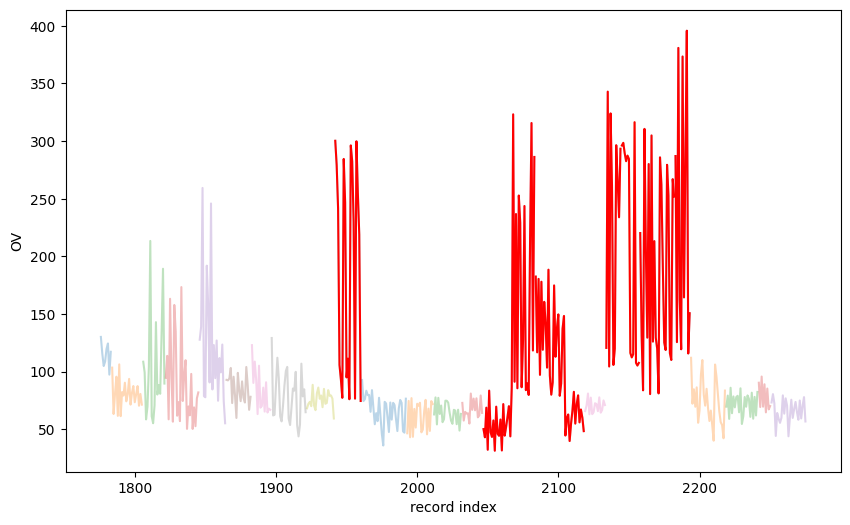

In [70]:
score_train = -model.score_samples(learn_batch.drop(41))

with open("../data/score/IF_train_score.pkl", "wb") as f:
    pickle.dump(score_train, f)

score_test  = -model.score_samples(test_batch)
thr = np.quantile(score_train, 0.90)
pred_iso = (score_test >= thr).astype(int)

plt.figure(figsize=(10, 6))
for batch_id, g in test.groupby("batch_id"):
    plt.plot(
        g.index,
        g["OV"],
        label=f"batch {batch_id}",
        alpha=0.3
    )

for i in range(25):
    # labelsが1のみフィルタしてプロット
    if pred_iso[i] == 1:
        mask = processe["batch_id"] == i+75
        plt.plot(
            processe.index[mask],
            processe["OV"][mask],
            linestyle='-',
            color='red'
        )
plt.xlabel("record index")
plt.ylabel("OV")
plt.savefig("../docs/output/spike_detection_IFmodel.png")
plt.show()